# Report project: ADAM Optimizer Notebook

This project was done in the scope of the CS-439 : Optimization for ML course. The project was done by :  
- Brioschi Riccardo 
- Mossinelli Giacomo
- Havolli Albias 

### Import useful libraries

In [13]:
# Import useful libraries for computation
import numpy as np

# Import torch and libraries to deal with NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pyhessian import hessian # Hessian computation
#from density_plot import get_esd_plot # ESD plot

# Import usefil library to visualize results
import matplotlib.pyplot as plt

# Importing the LeNet5 architecture we are going to use for our study and comparisons
from cnn_architectures import *

# Importing parameters to use with different optimizers before comparing them
import params

# Importing useful functions
from helpers import *

# Ignoring warnings to make the code more readable
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting the parameters and additional variables

In [2]:
# Defininig neural network's parameters and seed for reproducibility purposes
RANDOM_SEED = 42
IMG_SIZE = 32
N_CLASSES = 10
# Checking device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loading MNIST dataset, reshaping and plotting  data (ADAM)

In [3]:
# Loading data
transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
raw_mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=False)


## Loading CIFAR-10 Dataset

In [4]:
# Loading data
#transforms = transforms.Compose([transforms.Resize(IMG_SIZE),
                                 #transforms.ToTensor()])

# Load the MNIST dataset
raw_mnist_trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms)
raw_mnist_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms)

# Passing train data to the dataloader
train_loader = DataLoader(dataset=raw_mnist_trainset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=True)

# Passing test data to the dataloader
test_loader = DataLoader(dataset=raw_mnist_testset, 
                          batch_size=params.ADAM_BATCH_SIZE, 
                          shuffle=False)

In [4]:
# Reshaping train data (from 28*28 to 32*32) for visualization purposes
train_data, train_target = reshape_train_data(raw_mnist_trainset, DEVICE)
# Reshaping test data (from 28*28 to 32*32) for visualization purposes
test_data, test_target = reshape_test_data(raw_mnist_trainset, DEVICE)

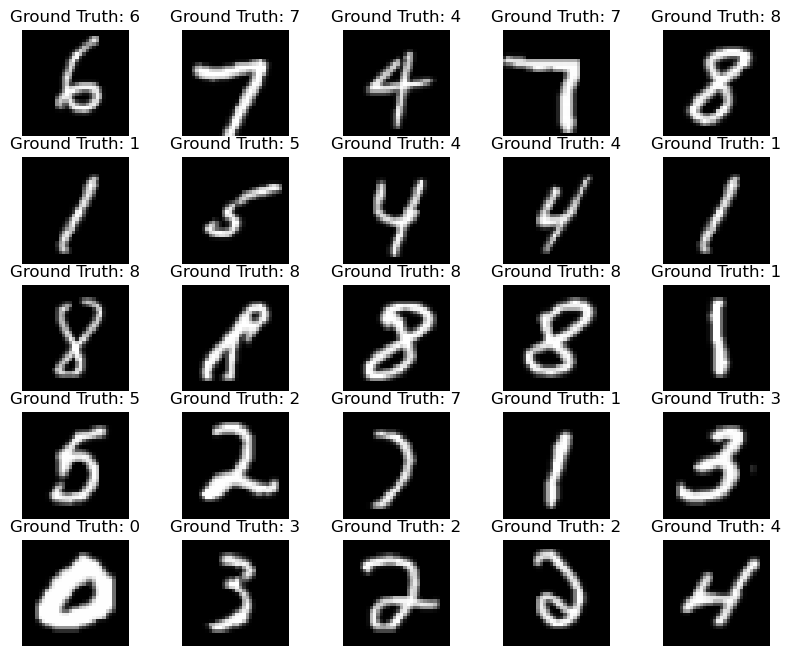

In [5]:
#plot some training examples with ground truth 
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader), size=(1,)).item()
    img = train_data[sample_idx]
    label = train_target[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Ground Truth: {}".format(train_target[sample_idx]))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model training and Model Evaluation using ADAM

First, we train our model using LeNet5. The model was trained using batches of size 32 and 15 epochs. Despite the low number of training episodes and iterations, the model seems to perform well.

In [4]:
# Initializing the model we are going to use in our study
model = LeNet5(num_classes=N_CLASSES)
# Defining the criterion (loss function) to be used during the training procedure
criterion = nn.CrossEntropyLoss()
# Defining and initializing the optimizer (ADAM in this notebook)
optimizer = torch.optim.Adam(model.parameters(), lr=params.ADAM_LEARNING_RATE)

Let's train and test our first model

In [5]:
model, optimizer, losses, grad_norms = training_loop(model, criterion, optimizer, train_loader, test_loader, params.ADAM_N_EPOCHS,
                                    DEVICE)

14:20:11 --- Epoch: 0	Train loss: 0.2353	Valid loss: 0.0951	Train accuracy: 97.14	Valid accuracy: 97.06
14:20:33 --- Epoch: 1	Train loss: 0.0811	Valid loss: 0.0674	Train accuracy: 98.10	Valid accuracy: 97.70
14:20:56 --- Epoch: 2	Train loss: 0.0574	Valid loss: 0.0506	Train accuracy: 98.69	Valid accuracy: 98.36
14:21:19 --- Epoch: 3	Train loss: 0.0450	Valid loss: 0.0444	Train accuracy: 99.01	Valid accuracy: 98.54
14:21:42 --- Epoch: 4	Train loss: 0.0366	Valid loss: 0.0461	Train accuracy: 99.18	Valid accuracy: 98.69
14:22:05 --- Epoch: 5	Train loss: 0.0302	Valid loss: 0.0431	Train accuracy: 99.29	Valid accuracy: 98.65
14:22:29 --- Epoch: 6	Train loss: 0.0238	Valid loss: 0.0493	Train accuracy: 99.15	Valid accuracy: 98.55
14:22:52 --- Epoch: 7	Train loss: 0.0232	Valid loss: 0.0444	Train accuracy: 99.42	Valid accuracy: 98.70
14:23:14 --- Epoch: 8	Train loss: 0.0202	Valid loss: 0.0445	Train accuracy: 99.51	Valid accuracy: 98.60
14:23:37 --- Epoch: 9	Train loss: 0.0179	Valid loss: 0.0458	Trai

Plot the gradient norm, which has been proven to be an important factor related to generalization properties of the architecture

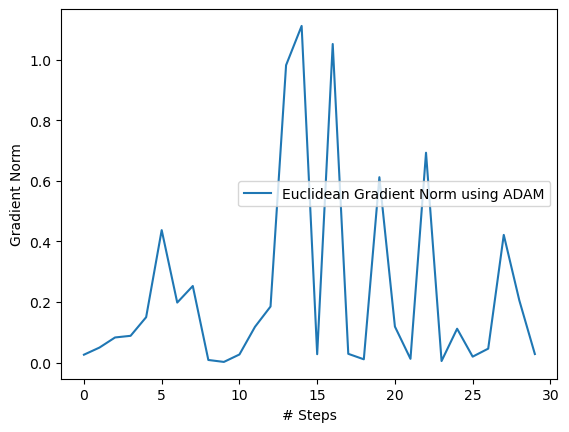

In [6]:
plot_gradient_norm(grad_norms[-30:], method = 'ADAM')

<Axes: xlabel='Predicted label', ylabel='True label'>

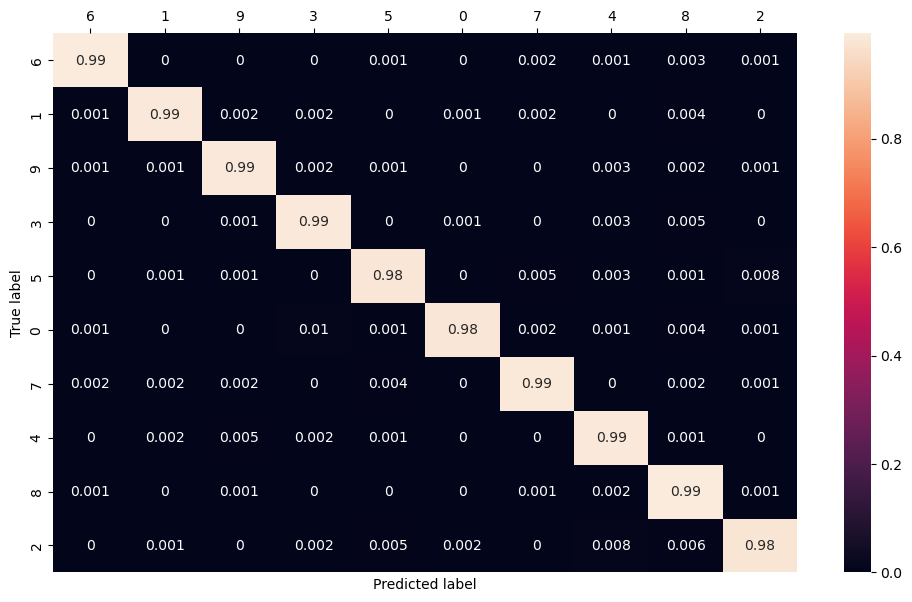

In [7]:
compute_confusion_matrix(test_loader, model, N_CLASSES)

We now start looking at the eigenvalues in order to see whether we've reached a flat or sharp minimum

In [14]:
# We now divide the training dataset into batches to compute the hessian of the loss evaluated in the solution
for inputs, targets in train_loader:
    break

# We move everything to the device
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

# We now compute the hessian matrix, to later retrieve the spectral norm and the eigenvalues
device_flag = True if torch.cuda.is_available() else False
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=device_flag)

# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 0.1296


In [15]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: 0.0509 0.1297
